In [7]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy, kurtosis, skew 
from src.utils.utils_networks import favor_centrality, godfhater_index
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

In [8]:

def favor_centrality(G, tol=0.0001):

    if len(G) == 0:
        raise nx.NetworkXPointlessConcept('cannot compute centrality for the null graph')
        
    g = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()

    supported_friends = (g.dot(g) > tol) & (g > tol)

    favor_centrality_list =  supported_friends.sum(axis=1)

    return dict(zip(G, favor_centrality_list)) 
    
def godfhater_index(G, tol=1.0e-10):

    if len(G) == 0:
        raise nx.NetworkXPointlessConcept('cannot compute centrality for the null graph')
        
    
    g = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
    
    godfhater_index_list = []
    for index, node in enumerate(G.nodes):
        prod = np.tensordot(g[:,index],g[:,index], axes = 0)
        prod_k_bigger_than_j = np.tril(prod,k=-1)
        
        prod_k_bigger_than_j = prod_k_bigger_than_j[(g.T < tol) & (g < tol)]

        gf_i = prod_k_bigger_than_j.sum()

        godfhater_index_list.append(gf_i)


    return dict(zip(G, godfhater_index_list))



ERROR! Session/line number was not unique in database. History logging moved to new session 2368


In [9]:
try:
    output_filepath
except:
    output_filepath = '../data/processed/'

In [10]:
data_path = os.path.join(output_filepath, 'panel_data.parquet')
df_model = pd.read_parquet(data_path)
country_universe = df_model.country.unique()

In [11]:
def get_granular_data(tol, year = '2015', graph = 'A_country.graphml', centrality = 'favor'):
    network_path = os.path.join(output_filepath, year, graph)
    G = nx.readwrite.graphml.read_graphml(network_path)

    if centrality == 'gfi':
        cent_dict  = godfhater_index(G,tol=tol)

    elif centrality == 'favor':
        cent_dict  = favor_centrality(G,tol=tol)
        
    centralities = [v for c,v in cent_dict.items() if c in country_universe]
    values = np.array(centralities).astype(float).reshape(-1, 1)

    
    pt = PowerTransformer()
    values = pt.fit_transform(values)
    

    return values[:,0]

In [12]:
def get_data(n, statistical_information = 'std', **kwargs):

    tols =  np.logspace(-n,-n+4,5)

    all_dfs = [] 
    for y in  range(2005, 2016):
        for tol in tols:
                
            # Granular dataset
            values = get_granular_data(tol,year=str(y), **kwargs)
            df_granular_loop = pd.DataFrame({'centrality':values})
            df_granular_loop['year'] = y
            df_granular_loop['tol'] = tol

            all_dfs.append(df_granular_loop)

    df_granular = pd.concat(all_dfs)

    df = df_granular.groupby(by=['tol','year']).centrality.agg(lambda x: compute_info(x, statistical_information=statistical_information)).reset_index()
    df.columns = ['tol', 'year', 'std']

    return df, df_granular

def compute_info(values, statistical_information = 'entropy'):
            
    if statistical_information == 'std':
        values -= values.mean() 
        return np.std(values)

    elif statistical_information == 'entropy':
        values = (values - values.mean())/values.std()
        values -= values.min()
        return entropy(values)

    elif statistical_information == 'kurtosis':
        values = (values - values.mean())/values.std()
        values -= values.min()
        return kurtosis(values)

    elif statistical_information == 'skew':
        values = (values - values.mean())/values.std()
        values -= values.min()
        return skew(values)

def plot_dinamic_range(n=9, **kwargs):
    
    net = 'Financial' if kwargs.get('graph') == 'A_country.graphml' else 'Migration'
    capital = 'coordination' if kwargs.get('centrality') == 'gfi' else 'favor'

    fig, (ax1, ax2)  = plt.subplots(2, 1, figsize = (9,6), sharex=True)

    df, df_granular = get_data( n = n, statistical_information = 'entropy', **kwargs)
    sns.boxplot(x='tol', y='std', data=df, ax=ax1)
    ax1.set_xlabel('$\epsilon$')
    ax1.set_ylabel('Entropy')
    ax1.title.set_text(f"{net} {capital} capital dinamic range for different $\epsilon$")

    df, df_granular = get_data( n = n, statistical_information = 'skew', **kwargs)
    sns.boxplot(x='tol', y='std',  data=df, ax=ax2)
    ax2.set_xlabel('$\epsilon$')
    ax2.set_ylabel('Skewness')
    ax2.title.set_text(f"{net} {capital} capital dinamic range for different $\epsilon$")
    ax2.axhline(ls='--')

    plt.show()

    data = df_granular.groupby('tol').filter(lambda x: np.std(x['centrality'])/np.mean(x['centrality'])>=0.0)
    data = df_granular.copy()
    data['tol'] = data['tol'].astype(str)

    sns.displot(data, x='centrality', hue='tol', kind="hist")

    plt.show()

    return data

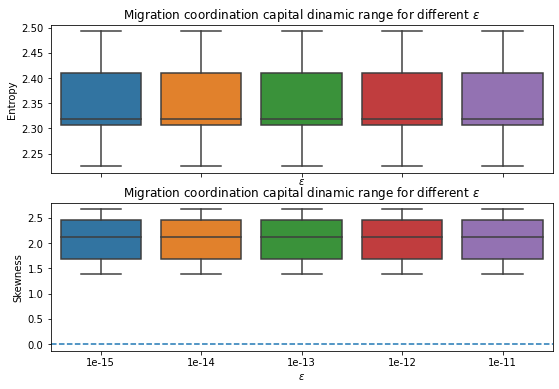

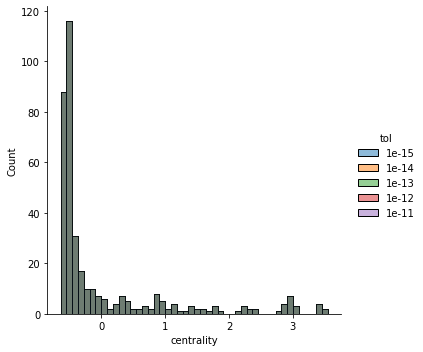

In [13]:
params = {'n':15, 'centrality':'gfi', 'graph':'migration_network.graphml'}
df_test = plot_dinamic_range(**params)

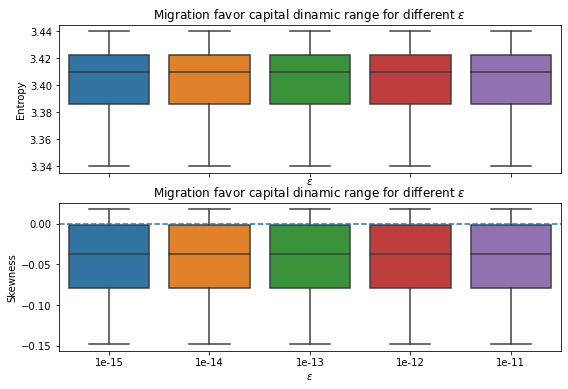

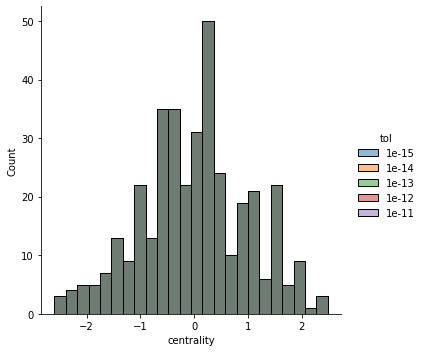

In [14]:
params = {'n':15, 'centrality':'favor', 'graph':'migration_network.graphml'}
df_test = plot_dinamic_range(**params)

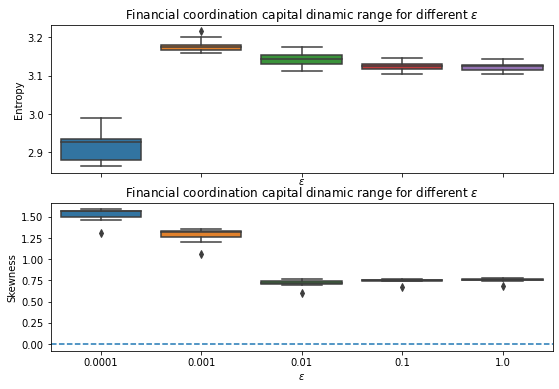

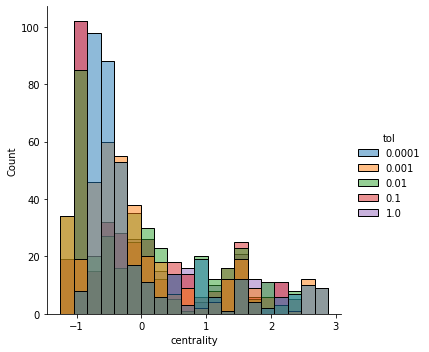

In [15]:
params = {'n':4, 'centrality':'gfi', 'graph':'A_country.graphml'}
df_test = plot_dinamic_range(**params)

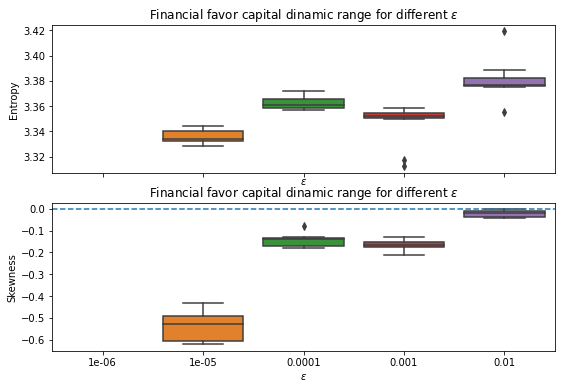

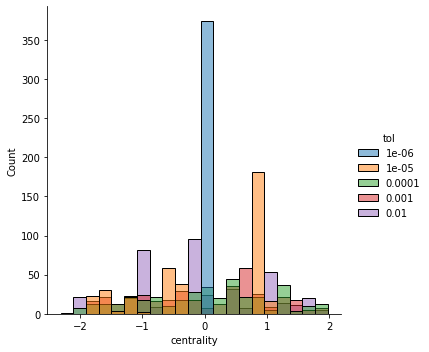

In [16]:
params = {'n':6, 'centrality':'favor', 'graph':'A_country.graphml'}
df_test = plot_dinamic_range(**params)